<a href="https://colab.research.google.com/github/marcelhas/akt3/blob/main/bosna_oder_kebap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import os

import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

/nix/store/qp5zys77biz7imbk6yy85q5pdv7qk84j-python3-3.11.6/bin/python: No module named pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
DATASET_SIZE = 60
BASE_DIR = './data_set/'
BATCH_SIZE = 4
EPOCHS = 30
SEED = 123
USE_BASE_MODEL = True

training_data = tf.keras.utils.image_dataset_from_directory(
  BASE_DIR + 'train',
  validation_split=0.2,
  subset="training",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    BASE_DIR + 'train',
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)


Found 54 files belonging to 2 classes.
Using 44 files for training.
Found 54 files belonging to 2 classes.
Using 10 files for validation.


In [3]:
base_model = tf.keras.applications.resnet_v2.ResNet50V2(
        include_top=False,
        pooling='max',
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
        weights='imagenet')

base_model.trainable = False

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])
data_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
])

In [5]:
if USE_BASE_MODEL:
    model = tf.keras.Sequential([
      data_preprocessing,
      data_augmentation,
      base_model,
      tf.keras.layers.Dense(512, 'relu'),
      tf.keras.layers.Dense(256, 'relu'),
      tf.keras.layers.Dense(1, 'sigmoid')
    ])
else:
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])



model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'], run_eagerly=False)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = model.fit(training_data, epochs=EPOCHS, validation_data=validation_data, callbacks=[early_stopping])
model.summary()
print(history.history.keys())

Epoch 1/30
11/11 [==============================] - 4s 189ms/step - loss: 9.0112 - accuracy: 0.4318 - val_loss: 5.9000 - val_accuracy: 0.4000
Epoch 2/30
11/11 [==============================] - 2s 134ms/step - loss: 3.4741 - accuracy: 0.6818 - val_loss: 2.2684 - val_accuracy: 0.8000
Epoch 3/30
11/11 [==============================] - 2s 136ms/step - loss: 0.8725 - accuracy: 0.8636 - val_loss: 0.7297 - val_accuracy: 0.8000
Epoch 4/30
11/11 [==============================] - 2s 144ms/step - loss: 0.4266 - accuracy: 0.9091 - val_loss: 0.6046 - val_accuracy: 0.9000
Epoch 5/30
11/11 [==============================] - 1s 133ms/step - loss: 0.2530 - accuracy: 0.9773 - val_loss: 1.6199 - val_accuracy: 0.8000
Epoch 6/30
11/11 [==============================] - 1s 130ms/step - loss: 0.0117 - accuracy: 1.0000 - val_loss: 1.1719 - val_accuracy: 0.8000
Epoch 7/30
11/11 [==============================] - 2s 136ms/step - loss: 4.1804e-04 - accuracy: 1.0000 - val_loss: 1.6588 - val_accuracy: 0.7000
Mo

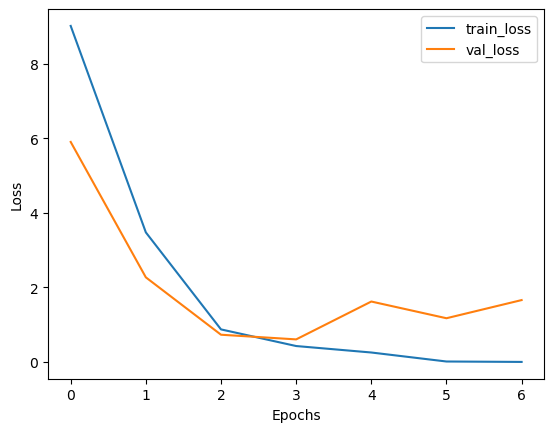

In [6]:
# Plot loss over iterations
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 6 files belonging to 2 classes.
2/2 [==============================] - 0s 58ms/step - loss: 0.0512 - accuracy: 1.0000
Test Loss: 0.05121302604675293, Test Accuracy: 1.0
2/2 [==============================] - 1s 54ms/step
Predictions:  [[0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]]
Labels:  [0 1 1 1 0 0]
[[2 1]
 [1 2]]


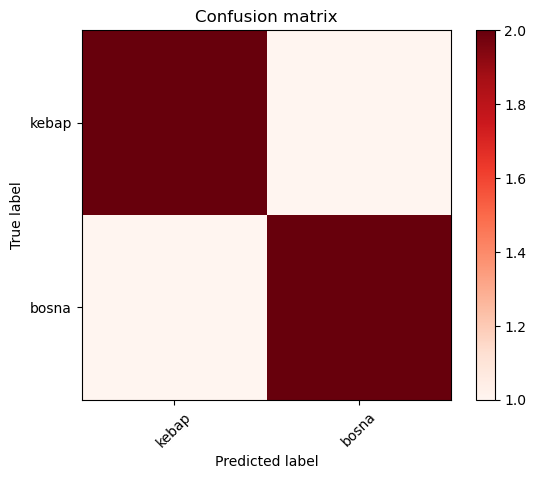

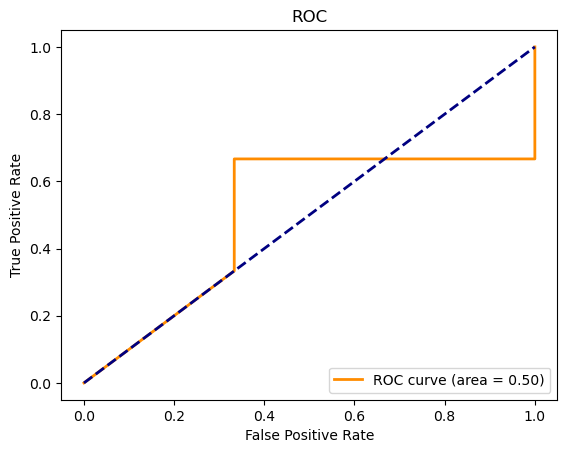

In [7]:
test_data = tf.keras.utils.image_dataset_from_directory(
  BASE_DIR + 'test',
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

test_loss, test_accuracy = model.evaluate(test_data)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

predictions = model.predict(test_data)
test_labels = np.concatenate([y for x, y in test_data], axis=0)
print('Predictions: ', np.round(predictions))
print('Labels: ', test_labels)

# Confusion matrix
cm = confusion_matrix(test_labels, np.round(predictions))
print(cm)
# Plot confusion matrix
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["kebap", "bosna"], rotation=45)
plt.yticks(tick_marks, ["kebap", "bosna"])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(test_labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()


In [8]:
# Save and load model
model.save('kebap_bosna_classifier.h5')

# Example of running inference
# Load the model
loaded_model = tf.keras.models.load_model('kebap_bosna_classifier.h5')

/nix/store/lb6g8yqaq1g771fs0wqng1269h4qkdpa-python3-3.11.6-env/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Documentation

### Introduction

The provided classifier distinguishes images of Bosnas and Kebaps. Its model is trained for 30 epochs on 60 pictures (30 Bosnas and 30 Kebaps) with a batch size of 10. The dataset was scraped from Google Images. We separated our dataset into training (72%), validation (18%) and test (10%) data. The data was encoded into one-hot vectors.

### Experiments

#### Different Image Sizes

The images were resized to 224x224 pixels. We experimented a lot with the image size. We tried 64x64, 128x128, 224x224 and 256x256. We found that 224x224 worked best for our model. We also tried to use grayscale images. This did not work well. The model was not able to distinguish between the two classes. It's very interesting that this specific size seemed to perform best over multiple experiments. We did not find out why that's the case though.

#### Different Batch Sizes

We found that larger batch sizes result in faster progress in training, but didn't always converge as fast. Smaller batch sizes trained slower, but converged faster. This does not make that big of a difference for our model as it is very small, but it's still interesting to see. It did not seem to make a big impact on the accuracy of the model though.

#### Different Number of Epochs

We tried different numbers of epochs at first, but then we decided to add early stopping to the model. The model stops training when the validation loss does not improve for 3 epochs. The model is then saved and the training is stopped. This is done to prevent overfitting and to save time. It also increases the accuracy of the model in general. Due to this we did not put too much thought in the number of epochs anymore. We just chose a high number and let the model stop when it is done.

#### Pretrained Models 

We tried different pretrained models. We tried ResNet50V2, InceptionV3, and MobileNetV2. We found that ResNet50V2 worked best for our model. It was the fastest and most accurate model. InceptionV3 seemed to be rather inaccurate, MobileNetV2 gave similar, but slightly worse results than ResNet50V2. We also tried to train our own model, surprisingly, this did not perform much worse than the pretrained models. This might be because the pretrained models were trained on a very different datasets.

### Lessons Learned

- Early stopping is very useful to prevent overfitting and to save time. It's also very easy to implement and very effective. A great benefit is that you don't have to think about the number of epochs anymore which takes away one variable.
- Data augmentation is very useful to increase the accuracy of the model, especially when you don't have a lot of data. 
- The amount of data is very important. We are sure that our model would perform way better if we had more data.
- Seed everything. It's very important to seed everything. This way you can reproduce your results and you can compare different models more easily.
- We think that because we just took the first 60 Google Images that we found, our model is very biased and the data is not of high quality. We think that this is the main reason why our model is not very accurate. We think that if we had more and better data, our model would perform way better.